In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp
from jax import grad, jit, random, partial, lax

import context
from models.PMF.pmf_model import logprior, loglikelihood
from models.PMF.util import R_train, R_test, load_PMF_MAP, rmse_PMF, get_rmse_list, mean_rating


from tuning.mamba import timed_sampler
from tuning.ksd import imq_KSD
from tuning.util import build_metric_curve_fn, get_mean_sd_ksd_curve
from util import wait_until_computed, flatten_param_list

from sgmcmcjax.kernels import build_sgld_kernel, build_sghmc_kernel, build_sgnht_kernel
from sgmcmcjax.kernels import build_sgldCV_kernel, build_sghmcCV_kernel, build_sgnhtCV_kernel


# PMF

In [16]:
data = (R_train,)


key = random.PRNGKey(0)
centering_value = load_PMF_MAP()
params_IC = load_PMF_MAP()

gridsearch_bs = int(0.1*R_train.shape[0])
dt_baseline = 1/R_train.shape[0]


In [34]:
from sgmcmcjax.util import build_grad_log_post
from jax import vmap, jit

grad_log_post = build_grad_log_post(loglikelihood, logprior, data)

from config import BASE_DIR

def load_PMF_NUTS_stds():
    return [np.genfromtxt(f"{BASE_DIR}/data/PMF_NUTS_stds/PMF_{idx}_std.txt") for idx in range(6)]


numpyro_stds = load_PMF_NUTS_stds()
flat_numpyro_std = flatten_param_list([numpyro_stds])[0]


def get_relative_error(samples, numpyro_stds=numpyro_stds):
    flat_samples = flatten_param_list(samples)
    flat_samples_std = flat_samples.std(axis=0)
#     flat_numpyro_std = flatten_param_list([numpyro_stds])[0]
    return np.linalg.norm(flat_samples_std-flat_numpyro_std)/np.linalg.norm(flat_numpyro_std)
    
    

def get_fb_grads_pmf(samples):
    """
    Return full-batch gradients for PMF samples
    samples list of PMF sample. Each PMF sample is a list of 6 arrays
    """
    return [grad_log_post(sam, R_train) for sam in samples]

def get_ksd_PMF(samples, thin_step):
    num_samples = len(samples)
    fb_grads = get_fb_grads_pmf(samples[::thin_step])
    flat_samples = flatten_param_list(samples[::thin_step])
    flat_grads = flatten_param_list(fb_grads)
    est_ksd = imq_KSD(flat_samples, flat_grads)
    
    # numpy error
    flat_samples_std = flat_samples.std(axis=0)
    numpyro_error = np.linalg.norm(flat_samples_std-flat_numpyro_std)/np.linalg.norm(flat_numpyro_std)
    
    rmse_list = get_rmse_list(samples, R_test, mean_rating)
    return est_ksd, numpyro_error, rmse_list

def assess_PMF_samples(samples, thin_step):
    num_samples = len(samples)
    print(f"\nAssessing the samples. Num samples: {num_samples}")
    est_ksd, numpyro_error, rmse_list = get_ksd_PMF(samples, thin_step)
    return est_ksd, numpyro_error, rmse_list, num_samples
    
def run_time_budget(key, time_budget, build_kernel, thin, dict_params, params_IC=load_PMF_MAP()):
    timed_sampler_factory = timed_sampler(build_kernel)
    my_timed_sampler = timed_sampler_factory(**dict_params)
    samples, _ = my_timed_sampler(key, time_budget, params_IC)
    return assess_PMF_samples(samples, thin)



### build partial kernels

In [35]:
partial_build_sgld = lambda dt, batch_size: build_sgld_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgldCV = lambda dt, batch_size: build_sgldCV_kernel(dt, loglikelihood, 
                                                    logprior, data, batch_size, centering_value)

partial_build_sghmc = lambda dt, L, batch_size: build_sghmc_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sghmcCV = lambda dt, L, batch_size: build_sghmcCV_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)

partial_build_sgnht = lambda dt, batch_size: build_sgnht_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgnhtCV = lambda dt, batch_size: build_sgnhtCV_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)

# time_budget = 5
# thin = 5

time_budget = 20
thin = 60


In [36]:
gridsearch_bs

8000

In [29]:
timed_sampler_factory = timed_sampler(partial_build_sgld)
my_timed_sampler = timed_sampler_factory(**{'batch_size': gridsearch_bs, 'dt': dt_baseline})
samples, _ = my_timed_sampler(key, 5, params_IC)
# return assess_PMF_samples(samples, 1)

In [30]:
len(samples)

2434

In [31]:
assess_PMF_samples(samples, 100)


Assessing the samples. Num samples: 2434


ValueError: too many values to unpack (expected 2)

In [ ]:
get_relative_error(samples[::10])

In [ ]:
mylist = get_rmse_list(samples, R_test, mean_rating)

In [ ]:
plt.plot(mylist)

# 1. A long run

- 1 million data points
- 20sec budget
- thin by 20

### sgld

In [76]:
sh_params = {'batch_size': 800, 'dt': 1e-05}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}


print("ksd, numpyro_error, num_samples:\n")
est_ksd, numpyro_error, rmse_list_sgld_mamba, num_samples = run_time_budget(key, time_budget, partial_build_sgld, thin, sh_params)
print(f"MAMBA: {float(est_ksd), numpyro_error, num_samples}")

est_ksd, numpyro_error, rmse_list_sgld_gridsearch, num_samples = run_time_budget(key, time_budget, partial_build_sgld, thin, gridsearch_params)
print(f"gridsearch: {float(est_ksd), numpyro_error, num_samples}")

est_ksd, numpyro_error, rmse_list_sgld_baseline, num_samples = run_time_budget(key, time_budget, partial_build_sgld, thin, baseline_params)
print(f"baseline: {float(est_ksd), numpyro_error, num_samples}")

ksd, numpyro_error, num_samples:


Assessing the samples. Num samples: 14424



MAMBA: (222.3230438232422, 0.7000136, 14424)

Assessing the samples. Num samples: 9239



gridsearch: (453.89788818359375, 1.222016, 9239)

Assessing the samples. Num samples: 9110



baseline: (248.40481567382812, 0.7251296, 9110)


1.1406999
1.2390687
1.1374693


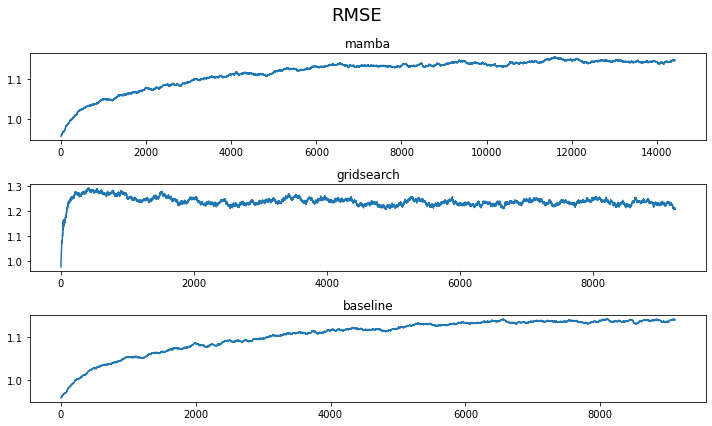

In [85]:
burnin_sgld_mamba = 6000
burnin_sgld_gridsearch = 500
burnin_sgld_baseline = 6000

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("RMSE", size=18)
ax[0].plot(rmse_list_sgld_mamba)
ax[0].set_title("mamba")
ax[1].plot(rmse_list_sgld_gridsearch)
ax[1].set_title("gridsearch")
ax[2].plot(rmse_list_sgld_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(rmse_list_sgld_mamba[burnin_sgld_mamba:]))
print(np.mean(rmse_list_sgld_gridsearch[burnin_sgld_gridsearch:]))
print(np.mean(rmse_list_sgld_baseline[burnin_sgld_baseline:]))

### sgld-cv

In [78]:
sh_params = {'batch_size': 800, 'dt': 1e-05}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print("ksd, numpyro_error, num_samples:\n")

est_ksd, numpyro_error, rmse_list_sgldCV_mamba, num_samples = run_time_budget(key, time_budget, partial_build_sgldCV, thin, sh_params)
print(f"MAMBA: {float(est_ksd), numpyro_error, num_samples}")
est_ksd, numpyro_error, rmse_list_sgldCV_gridsearch, num_samples = run_time_budget(key, time_budget, partial_build_sgldCV, thin, gridsearch_params)
print(f"gridsearch: {float(est_ksd), numpyro_error, num_samples}")
est_ksd, numpyro_error, rmse_list_sgldCV_baseline, num_samples = run_time_budget(key, time_budget, partial_build_sgldCV, thin, baseline_params)
print(f"baseline: {float(est_ksd), numpyro_error, num_samples}")


ksd, numpyro_error, num_samples:


Assessing the samples. Num samples: 10247



MAMBA: (247.45919799804688, 0.733772, 10247)

Assessing the samples. Num samples: 6415



gridsearch: (566.5340576171875, 1.3559806, 6415)

Assessing the samples. Num samples: 6585



baseline: (290.04248046875, 0.7537554, 6585)
290.04248 0.7537554 6585
290.04248 0.7537554 6585
290.04248 0.7537554 6585


1.133148
1.2462232
1.1259294


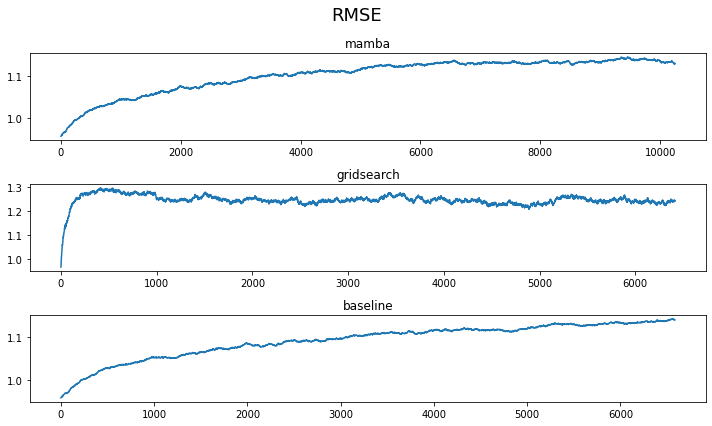

In [86]:
burnin_sgldCV_mamba = 6000
burnin_sgldCV_gridsearch = 500
burnin_sgldCV_baseline = 4000

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("RMSE", size=18)
ax[0].plot(rmse_list_sgldCV_mamba)
ax[0].set_title("mamba")
ax[1].plot(rmse_list_sgldCV_gridsearch)
ax[1].set_title("gridsearch")
ax[2].plot(rmse_list_sgldCV_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(rmse_list_sgldCV_mamba[burnin_sgldCV_mamba:]))
print(np.mean(rmse_list_sgldCV_gridsearch[burnin_sgldCV_gridsearch:]))
print(np.mean(rmse_list_sgldCV_baseline[burnin_sgldCV_baseline:]))

## sghmc

In [81]:
sh_params = {'batch_size': 800, 'L': 5, 'dt': 1e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-5}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}

print("ksd, numpyro_error, num_samples:\n")

est_ksd, numpyro_error, rmse_list_sghmc_mamba, num_samples = run_time_budget(key, time_budget, partial_build_sghmc, thin, sh_params)
print(f"MAMBA: {float(est_ksd), numpyro_error, num_samples}")
est_ksd, numpyro_error, rmse_list_sghmc_gridsearch, num_samples = run_time_budget(key, time_budget, partial_build_sghmc, thin, gridsearch_params)
print(f"gridsearch: {float(est_ksd), numpyro_error, num_samples}")
est_ksd, numpyro_error, rmse_list_sghmc_baseline, num_samples = run_time_budget(key, time_budget, partial_build_sghmc, thin, baseline_params)
print(f"baseline: {float(est_ksd), numpyro_error, num_samples}")


ksd, numpyro_error, num_samples:


Assessing the samples. Num samples: 3375



MAMBA: (445.1099548339844, 0.8018765, 3375)

Assessing the samples. Num samples: 1055



gridsearch: (3465.5302734375, 0.52726996, 1055)

Assessing the samples. Num samples: 1031



baseline: (3941.710205078125, 0.50353265, 1031)


1.1242652
1.2512119
1.2519764


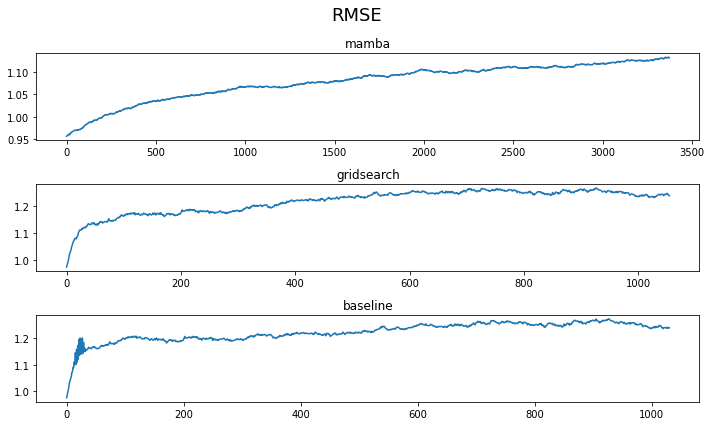

In [89]:
burnin_sghmc_mamba = 3000
burnin_sghmc_gridsearch = 600
burnin_sghmc_baseline = 600

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("RMSE", size=18)
ax[0].plot(rmse_list_sghmc_mamba)
ax[0].set_title("mamba")
ax[1].plot(rmse_list_sghmc_gridsearch)
ax[1].set_title("gridsearch")
ax[2].plot(rmse_list_sghmc_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(rmse_list_sghmc_mamba[burnin_sghmc_mamba:]))
print(np.mean(rmse_list_sghmc_gridsearch[burnin_sghmc_gridsearch:]))
print(np.mean(rmse_list_sghmc_baseline[burnin_sghmc_baseline:]))

## sghmc-cv

In [82]:
sh_params = {'batch_size': 80, 'L': 5, 'dt': 1e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-5}
baseline_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}

print("ksd, numpyro_error, num_samples:\n")

est_ksd, numpyro_error, rmse_list_sghmcCV_mamba, num_samples = run_time_budget(key, time_budget, partial_build_sghmcCV, thin, sh_params)
print(f"MAMBA: {float(est_ksd), numpyro_error, num_samples}")
est_ksd, numpyro_error, rmse_list_sghmcCV_gridsearch, num_samples = run_time_budget(key, time_budget, partial_build_sghmcCV, thin, gridsearch_params)
print(f"gridsearch: {float(est_ksd), numpyro_error, num_samples}")
est_ksd, numpyro_error, rmse_list_sghmcCV_baseline, num_samples = run_time_budget(key, time_budget, partial_build_sghmcCV, thin, baseline_params)
print(f"baseline: {float(est_ksd), numpyro_error, num_samples}")


ksd, numpyro_error, num_samples:


Assessing the samples. Num samples: 2797



MAMBA: (502.713623046875, 0.81492513, 2797)

Assessing the samples. Num samples: 749



gridsearch: (4777.5498046875, 0.578255, 749)

Assessing the samples. Num samples: 762



baseline: (5153.6728515625, 0.5548111, 762)


1.1107484
1.2476312
1.2445937


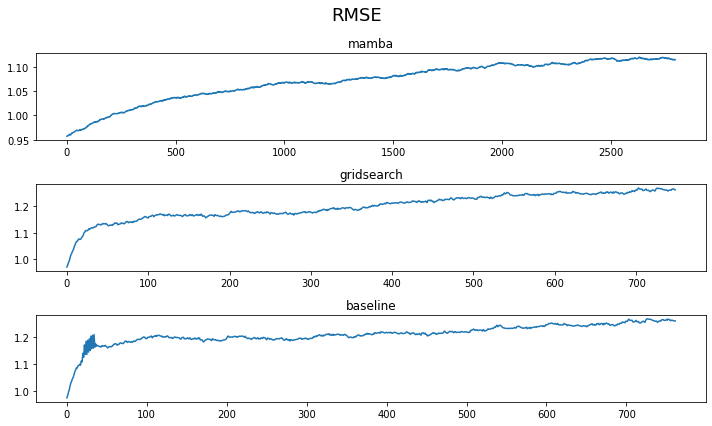

In [91]:
burnin_sghmcCV_mamba = 2000
burnin_sghmcCV_gridsearch = 500
burnin_sghmcCV_baseline = 500

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("RMSE", size=18)
ax[0].plot(rmse_list_sghmcCV_mamba)
ax[0].set_title("mamba")
ax[1].plot(rmse_list_sghmcCV_gridsearch)
ax[1].set_title("gridsearch")
ax[2].plot(rmse_list_sghmcCV_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(rmse_list_sghmcCV_mamba[burnin_sghmcCV_mamba:]))
print(np.mean(rmse_list_sghmcCV_gridsearch[burnin_sghmcCV_gridsearch:]))
print(np.mean(rmse_list_sghmcCV_baseline[burnin_sghmcCV_baseline:]))

## sgnht

In [83]:
sh_params = {'batch_size': 8000, 'dt': 3.1622778e-05}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 3.1622776e-06}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print("ksd, numpyro_error, num_samples:\n")

est_ksd, numpyro_error, rmse_list_sgnht_mamba, num_samples = run_time_budget(key, time_budget, partial_build_sgnht, thin, sh_params)
print(f"MAMBA: {float(est_ksd), numpyro_error, num_samples}")
est_ksd, numpyro_error, rmse_list_sgnht_gridsearch, num_samples = run_time_budget(key, time_budget, partial_build_sgnht, thin, gridsearch_params)
print(f"gridsearch: {float(est_ksd), numpyro_error, num_samples}")
est_ksd, numpyro_error, rmse_list_sgnht_baseline, num_samples = run_time_budget(key, time_budget, partial_build_sgnht, thin, baseline_params)
print(f"baseline: {float(est_ksd), numpyro_error, num_samples}")


ksd, numpyro_error, num_samples:


Assessing the samples. Num samples: 8908



MAMBA: (176.61260986328125, 0.43326434, 8908)

Assessing the samples. Num samples: 9365



gridsearch: (173.84097290039062, 0.44456467, 9365)

Assessing the samples. Num samples: 7241



baseline: (193.50119018554688, 0.41896576, 7241)


1.0681487
1.154149
1.113486


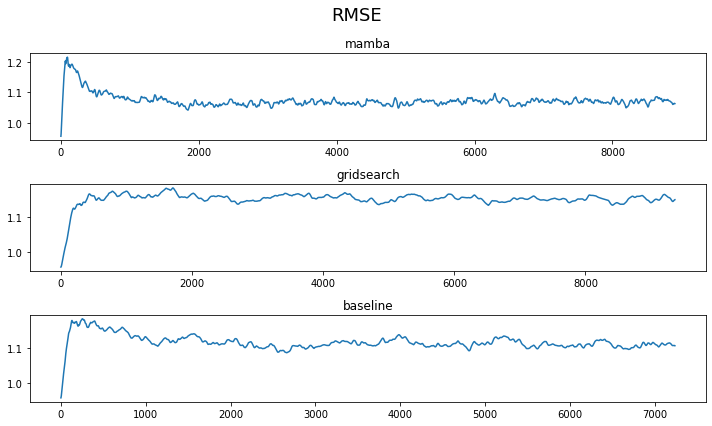

In [94]:
burnin_sgnht_mamba = 2000
burnin_sgnht_gridsearch = 1000
burnin_sgnht_baseline = 1000

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("RMSE", size=18)
ax[0].plot(rmse_list_sgnht_mamba)
ax[0].set_title("mamba")
ax[1].plot(rmse_list_sgnht_gridsearch)
ax[1].set_title("gridsearch")
ax[2].plot(rmse_list_sgnht_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(rmse_list_sgnht_mamba[burnin_sgnht_mamba:]))
print(np.mean(rmse_list_sgnht_gridsearch[burnin_sgnht_gridsearch:]))
print(np.mean(rmse_list_sgnht_baseline[burnin_sgnht_baseline:]))

## sgnht-cv

In [84]:
sh_params = {'batch_size': 8000, 'dt': 1e-05}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 3.1622776e-06}
baseline_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}

print("ksd, numpyro_error, num_samples:\n")

est_ksd, numpyro_error, rmse_list_sgnhtCV_mamba, num_samples = run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, sh_params)
print(f"MAMBA: {float(est_ksd), numpyro_error, num_samples}")
est_ksd, numpyro_error, rmse_list_sgnhtCV_gridsearch, num_samples = run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, gridsearch_params)
print(f"gridsearch: {float(est_ksd), numpyro_error, num_samples}")
est_ksd, numpyro_error, rmse_list_sgnhtCV_baseline, num_samples = run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, baseline_params)
print(f"baseline: {float(est_ksd), numpyro_error, num_samples}")



ksd, numpyro_error, num_samples:


Assessing the samples. Num samples: 6304



MAMBA: (208.07083129882812, 0.3854795, 6304)

Assessing the samples. Num samples: 4685



gridsearch: (253.83509826660156, 0.4890493, 4685)

Assessing the samples. Num samples: 6150



baseline: (216.89047241210938, 0.38660297, 6150)


1.1218779
1.1594683
1.1155107


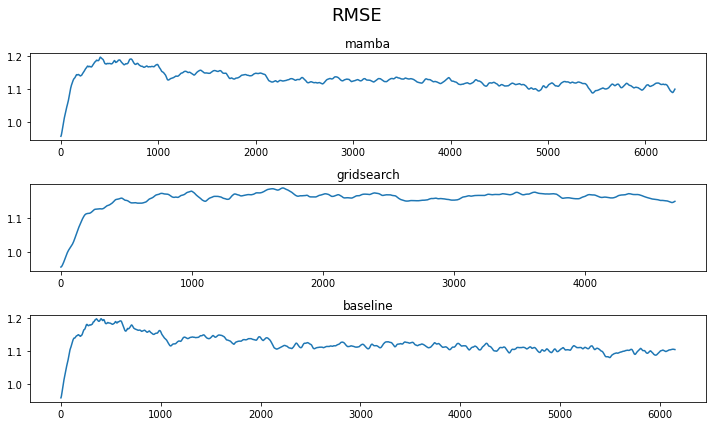

In [96]:
burnin_sgnhtCV_mamba = 1500
burnin_sgnhtCV_gridsearch = 100
burnin_sgnhtCV_baseline = 1000

fig, ax = plt.subplots(3, figsize=(10,6))
plt.suptitle("RMSE", size=18)
ax[0].plot(rmse_list_sgnhtCV_mamba)
ax[0].set_title("mamba")
ax[1].plot(rmse_list_sgnhtCV_gridsearch)
ax[1].set_title("gridsearch")
ax[2].plot(rmse_list_sgnhtCV_baseline)
ax[2].set_title("baseline")

plt.tight_layout()

print(np.mean(rmse_list_sgnhtCV_mamba[burnin_sgnhtCV_mamba:]))
print(np.mean(rmse_list_sgnhtCV_gridsearch[burnin_sgnhtCV_gridsearch:]))
print(np.mean(rmse_list_sgnhtCV_baseline[burnin_sgnhtCV_baseline:]))

# 2. KSD curves

### sgld

In [39]:
error_fn_ksd_curve = partial(get_ksd_PMF, thin_step=30)
list_time_budget = [2, 4, 6, 8, 10]

In [8]:
dict_params = {'batch_size': 800, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 800, 'dt': 1e-05}

Iteration 0/10
Budget: 2, num_samples = 1563
Budget: 4, num_samples = 3128
Budget: 6, num_samples = 4414
Budget: 8, num_samples = 5582
Budget: 10, num_samples = 6788

Iteration 1/10
Budget: 2, num_samples = 1334
Budget: 4, num_samples = 2428
Budget: 6, num_samples = 3775
Budget: 8, num_samples = 5297
Budget: 10, num_samples = 6731

Iteration 2/10
Budget: 2, num_samples = 1541
Budget: 4, num_samples = 2601
Budget: 6, num_samples = 3595
Budget: 8, num_samples = 4899
Budget: 10, num_samples = 6129

Iteration 3/10
Budget: 2, num_samples = 1430
Budget: 4, num_samples = 2604
Budget: 6, num_samples = 3545
Budget: 8, num_samples = 4633
Budget: 10, num_samples = 6395

Iteration 4/10
Budget: 2, num_samples = 1543
Budget: 4, num_samples = 2735
Budget: 6, num_samples = 4098
Budget: 8, num_samples = 5556
Budget: 10, num_samples = 6651

Iteration 5/10
Budget: 2, num_samples = 1569
Budget: 4, num_samples = 2787
Budget: 6, num_samples = 4056
Budget: 8, num

In [14]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 0.00031622776}

Iteration 0/10
Budget: 2, num_samples = 984
Budget: 4, num_samples = 1904
Budget: 6, num_samples = 2737
Budget: 8, num_samples = 3687
Budget: 10, num_samples = 4722

Iteration 1/10
Budget: 2, num_samples = 977
Budget: 4, num_samples = 1948
Budget: 6, num_samples = 2548
Budget: 8, num_samples = 3795
Budget: 10, num_samples = 4685

Iteration 2/10
Budget: 2, num_samples = 975
Budget: 4, num_samples = 1800
Budget: 6, num_samples = 2529
Budget: 8, num_samples = 3733
Budget: 10, num_samples = 4765

Iteration 3/10
Budget: 2, num_samples = 958
Budget: 4, num_samples = 1872
Budget: 6, num_samples = 2553
Budget: 8, num_samples = 3701
Budget: 10, num_samples = 4637

Iteration 4/10
Budget: 2, num_samples = 952
Budget: 4, num_samples = 1794
Budget: 6, num_samples = 2528
Budget: 8, num_samples = 3659
Budget: 10, num_samples = 4588

Iteration 5/10
Budget: 2, num_samples = 956
Budget: 4, num_samples = 1819
Budget: 6, num_samples = 2567
Budget: 8, 

In [40]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 1.25e-05}

Iteration 0/10
Budget: 2, num_samples = 970
Budget: 4, num_samples = 1934
Budget: 6, num_samples = 2920
Budget: 8, num_samples = 3743
Budget: 10, num_samples = 4601

Iteration 1/10
Budget: 2, num_samples = 952
Budget: 4, num_samples = 1838
Budget: 6, num_samples = 2671
Budget: 8, num_samples = 3347
Budget: 10, num_samples = 3686

Iteration 2/10
Budget: 2, num_samples = 838
Budget: 4, num_samples = 1652
Budget: 6, num_samples = 2428
Budget: 8, num_samples = 3175
Budget: 10, num_samples = 3933

Iteration 3/10
Budget: 2, num_samples = 928
Budget: 4, num_samples = 1765
Budget: 6, num_samples = 2618
Budget: 8, num_samples = 3550
Budget: 10, num_samples = 4466

Iteration 4/10
Budget: 2, num_samples = 975
Budget: 4, num_samples = 1818
Budget: 6, num_samples = 1490
Budget: 8, num_samples = 2420
Budget: 10, num_samples = 4341

Iteration 5/10
Budget: 2, num_samples = 1027
Budget: 4, num_samples = 1904
Budget: 6, num_samples = 2635
Budget: 8, num_

### sgld-cv

In [9]:
dict_params = {'batch_size': 800, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 800, 'dt': 1e-05}

Iteration 0/10
Budget: 2, num_samples = 1092
Budget: 4, num_samples = 1793
Budget: 6, num_samples = 2686
Budget: 8, num_samples = 3551
Budget: 10, num_samples = 4363

Iteration 1/10
Budget: 2, num_samples = 965
Budget: 4, num_samples = 1929
Budget: 6, num_samples = 2734
Budget: 8, num_samples = 3619
Budget: 10, num_samples = 4453

Iteration 2/10
Budget: 2, num_samples = 969
Budget: 4, num_samples = 1807
Budget: 6, num_samples = 2549
Budget: 8, num_samples = 3542
Budget: 10, num_samples = 4309

Iteration 3/10
Budget: 2, num_samples = 986
Budget: 4, num_samples = 1968
Budget: 6, num_samples = 2872
Budget: 8, num_samples = 3774
Budget: 10, num_samples = 4533

Iteration 4/10
Budget: 2, num_samples = 1012
Budget: 4, num_samples = 1931
Budget: 6, num_samples = 2612
Budget: 8, num_samples = 3695
Budget: 10, num_samples = 4639

Iteration 5/10
Budget: 2, num_samples = 958
Budget: 4, num_samples = 1861
Budget: 6, num_samples = 2764
Budget: 8, num_sam

In [16]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 0.00031622776}

Iteration 0/10
Budget: 2, num_samples = 644
Budget: 4, num_samples = 1187
Budget: 6, num_samples = 1607
Budget: 8, num_samples = 2287
Budget: 10, num_samples = 3032

Iteration 1/10
Budget: 2, num_samples = 630
Budget: 4, num_samples = 1182
Budget: 6, num_samples = 1820
Budget: 8, num_samples = 2258
Budget: 10, num_samples = 3012

Iteration 2/10
Budget: 2, num_samples = 629
Budget: 4, num_samples = 1193
Budget: 6, num_samples = 1806
Budget: 8, num_samples = 2243
Budget: 10, num_samples = 3001

Iteration 3/10
Budget: 2, num_samples = 584
Budget: 4, num_samples = 1195
Budget: 6, num_samples = 1819
Budget: 8, num_samples = 2228
Budget: 10, num_samples = 2816

Iteration 4/10
Budget: 2, num_samples = 578
Budget: 4, num_samples = 1115
Budget: 6, num_samples = 1697
Budget: 8, num_samples = 2147
Budget: 10, num_samples = 2631

Iteration 5/10
Budget: 2, num_samples = 550
Budget: 4, num_samples = 1218
Budget: 6, num_samples = 1785
Budget: 8, 

In [41]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 1.25e-05}

Iteration 0/10
Budget: 2, num_samples = 682
Budget: 4, num_samples = 1281
Budget: 6, num_samples = 1615
Budget: 8, num_samples = 2157
Budget: 10, num_samples = 2949

Iteration 1/10
Budget: 2, num_samples = 594
Budget: 4, num_samples = 1192
Budget: 6, num_samples = 1756
Budget: 8, num_samples = 2458
Budget: 10, num_samples = 2891

Iteration 2/10
Budget: 2, num_samples = 630
Budget: 4, num_samples = 1243
Budget: 6, num_samples = 1762
Budget: 8, num_samples = 2358
Budget: 10, num_samples = 3045

Iteration 3/10
Budget: 2, num_samples = 633
Budget: 4, num_samples = 1250
Budget: 6, num_samples = 1769
Budget: 8, num_samples = 2294
Budget: 10, num_samples = 2909

Iteration 4/10
Budget: 2, num_samples = 630
Budget: 4, num_samples = 1238
Budget: 6, num_samples = 1749
Budget: 8, num_samples = 2279
Budget: 10, num_samples = 2955

Iteration 5/10
Budget: 2, num_samples = 596
Budget: 4, num_samples = 1175
Budget: 6, num_samples = 1750
Budget: 8, num_s

### sghmc

In [10]:
dict_params = {'batch_size': 800, 'L': 5, 'dt': 1e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 800, 'L': 5, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 322
Budget: 4, num_samples = 563
Budget: 6, num_samples = 739
Budget: 8, num_samples = 984
Budget: 10, num_samples = 1217

Iteration 1/10
Budget: 2, num_samples = 264
Budget: 4, num_samples = 534
Budget: 6, num_samples = 802
Budget: 8, num_samples = 1064
Budget: 10, num_samples = 1288

Iteration 2/10
Budget: 2, num_samples = 243
Budget: 4, num_samples = 491
Budget: 6, num_samples = 771
Budget: 8, num_samples = 1050
Budget: 10, num_samples = 1278

Iteration 3/10
Budget: 2, num_samples = 231
Budget: 4, num_samples = 476
Budget: 6, num_samples = 747
Budget: 8, num_samples = 1049
Budget: 10, num_samples = 1287

Iteration 4/10
Budget: 2, num_samples = 248
Budget: 4, num_samples = 489
Budget: 6, num_samples = 759
Budget: 8, num_samples = 1037
Budget: 10, num_samples = 1322

Iteration 5/10
Budget: 2, num_samples = 259
Budget: 4, num_samples = 504
Budget: 6, num_samples = 743
Budget: 8, num_samples = 

In [18]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'L': 10, 'dt': 1e-05}

Iteration 0/10
Budget: 2, num_samples = 111
Budget: 4, num_samples = 220
Budget: 6, num_samples = 329
Budget: 8, num_samples = 434
Budget: 10, num_samples = 541

Iteration 1/10
Budget: 2, num_samples = 108
Budget: 4, num_samples = 212
Budget: 6, num_samples = 320
Budget: 8, num_samples = 428
Budget: 10, num_samples = 534

Iteration 2/10
Budget: 2, num_samples = 106
Budget: 4, num_samples = 214
Budget: 6, num_samples = 314
Budget: 8, num_samples = 425
Budget: 10, num_samples = 534

Iteration 3/10
Budget: 2, num_samples = 104
Budget: 4, num_samples = 204
Budget: 6, num_samples = 282
Budget: 8, num_samples = 370
Budget: 10, num_samples = 520

Iteration 4/10
Budget: 2, num_samples = 104
Budget: 4, num_samples = 210
Budget: 6, num_samples = 317
Budget: 8, num_samples = 430
Budget: 10, num_samples = 531

Iteration 5/10
Budget: 2, num_samples = 106
Budget: 4, num_samples = 218
Budget: 6, num_samples = 320
Budget: 8, num_samples = 426
Bud

In [42]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'L': 10, 'dt': 1.25e-05}

Iteration 0/10
Budget: 2, num_samples = 121
Budget: 4, num_samples = 224
Budget: 6, num_samples = 295
Budget: 8, num_samples = 375
Budget: 10, num_samples = 498

Iteration 1/10
Budget: 2, num_samples = 101
Budget: 4, num_samples = 200
Budget: 6, num_samples = 291
Budget: 8, num_samples = 379
Budget: 10, num_samples = 461

Iteration 2/10
Budget: 2, num_samples = 98
Budget: 4, num_samples = 193
Budget: 6, num_samples = 298
Budget: 8, num_samples = 395
Budget: 10, num_samples = 482

Iteration 3/10
Budget: 2, num_samples = 97
Budget: 4, num_samples = 194
Budget: 6, num_samples = 291
Budget: 8, num_samples = 384
Budget: 10, num_samples = 481

Iteration 4/10
Budget: 2, num_samples = 97
Budget: 4, num_samples = 189
Budget: 6, num_samples = 281
Budget: 8, num_samples = 383
Budget: 10, num_samples = 495

Iteration 5/10
Budget: 2, num_samples = 102
Budget: 4, num_samples = 199
Budget: 6, num_samples = 285
Budget: 8, num_samples = 368
Bud

### sghmc-CV

In [11]:
dict_params = {'batch_size': 80, 'L': 5, 'dt': 1e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 80, 'L': 5, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 307
Budget: 4, num_samples = 534
Budget: 6, num_samples = 740
Budget: 8, num_samples = 911
Budget: 10, num_samples = 1183

Iteration 1/10
Budget: 2, num_samples = 255
Budget: 4, num_samples = 513
Budget: 6, num_samples = 762
Budget: 8, num_samples = 1014
Budget: 10, num_samples = 1241

Iteration 2/10
Budget: 2, num_samples = 246
Budget: 4, num_samples = 482
Budget: 6, num_samples = 701
Budget: 8, num_samples = 927
Budget: 10, num_samples = 1206

Iteration 3/10
Budget: 2, num_samples = 241
Budget: 4, num_samples = 488
Budget: 6, num_samples = 678
Budget: 8, num_samples = 928
Budget: 10, num_samples = 1201

Iteration 4/10
Budget: 2, num_samples = 246
Budget: 4, num_samples = 469
Budget: 6, num_samples = 721
Budget: 8, num_samples = 932
Budget: 10, num_samples = 1100

Iteration 5/10
Budget: 2, num_samples = 227
Budget: 4, num_samples = 468
Budget: 6, num_samples = 723
Budget: 8, num_samples = 1003

In [20]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'L': 10, 'dt': 1e-05}

Iteration 0/10
Budget: 2, num_samples = 81
Budget: 4, num_samples = 162
Budget: 6, num_samples = 242
Budget: 8, num_samples = 316
Budget: 10, num_samples = 397

Iteration 1/10
Budget: 2, num_samples = 76
Budget: 4, num_samples = 152
Budget: 6, num_samples = 228
Budget: 8, num_samples = 305
Budget: 10, num_samples = 379

Iteration 2/10
Budget: 2, num_samples = 73
Budget: 4, num_samples = 151
Budget: 6, num_samples = 228
Budget: 8, num_samples = 309
Budget: 10, num_samples = 386

Iteration 3/10
Budget: 2, num_samples = 75
Budget: 4, num_samples = 156
Budget: 6, num_samples = 231
Budget: 8, num_samples = 294
Budget: 10, num_samples = 375

Iteration 4/10
Budget: 2, num_samples = 79
Budget: 4, num_samples = 155
Budget: 6, num_samples = 229
Budget: 8, num_samples = 300
Budget: 10, num_samples = 377

Iteration 5/10
Budget: 2, num_samples = 78
Budget: 4, num_samples = 156
Budget: 6, num_samples = 228
Budget: 8, num_samples = 306
Budget: 1

In [44]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'L': 10, 'dt': 1.25e-05}

Iteration 0/10
Budget: 2, num_samples = 85
Budget: 4, num_samples = 168
Budget: 6, num_samples = 248
Budget: 8, num_samples = 319
Budget: 10, num_samples = 411

Iteration 1/10
Budget: 2, num_samples = 84
Budget: 4, num_samples = 165
Budget: 6, num_samples = 245
Budget: 8, num_samples = 297
Budget: 10, num_samples = 333

Iteration 2/10
Budget: 2, num_samples = 68
Budget: 4, num_samples = 133
Budget: 6, num_samples = 204
Budget: 8, num_samples = 290
Budget: 10, num_samples = 370

Iteration 3/10
Budget: 2, num_samples = 73
Budget: 4, num_samples = 145
Budget: 6, num_samples = 213
Budget: 8, num_samples = 278
Budget: 10, num_samples = 362

Iteration 4/10
Budget: 2, num_samples = 75
Budget: 4, num_samples = 146
Budget: 6, num_samples = 217
Budget: 8, num_samples = 286
Budget: 10, num_samples = 351

Iteration 5/10
Budget: 2, num_samples = 71
Budget: 4, num_samples = 143
Budget: 6, num_samples = 220
Budget: 8, num_samples = 294
Budget

### sgnht

In [12]:
dict_params = {'batch_size': 8000, 'dt': 3.1622778e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 3.1622778e-05}

Iteration 0/10
Budget: 2, num_samples = 832
Budget: 4, num_samples = 1416
Budget: 6, num_samples = 2145
Budget: 8, num_samples = 2842
Budget: 10, num_samples = 3628

Iteration 1/10
Budget: 2, num_samples = 717
Budget: 4, num_samples = 1425
Budget: 6, num_samples = 2154
Budget: 8, num_samples = 2877
Budget: 10, num_samples = 3552

Iteration 2/10
Budget: 2, num_samples = 760
Budget: 4, num_samples = 1474
Budget: 6, num_samples = 2177
Budget: 8, num_samples = 2986
Budget: 10, num_samples = 3665

Iteration 3/10
Budget: 2, num_samples = 806
Budget: 4, num_samples = 1563
Budget: 6, num_samples = 2150
Budget: 8, num_samples = 2785
Budget: 10, num_samples = 3517

Iteration 4/10
Budget: 2, num_samples = 765
Budget: 4, num_samples = 1551
Budget: 6, num_samples = 2072
Budget: 8, num_samples = 2410
Budget: 10, num_samples = 2895

Iteration 5/10
Budget: 2, num_samples = 724
Budget: 4, num_samples = 1262
Budget: 6, num_samples = 1796
Budget: 8, 

In [22]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 3.1622776e-06}

Iteration 0/10
Budget: 2, num_samples = 915
Budget: 4, num_samples = 1725
Budget: 6, num_samples = 2493
Budget: 8, num_samples = 2905
Budget: 10, num_samples = 3732

Iteration 1/10
Budget: 2, num_samples = 826
Budget: 4, num_samples = 1698
Budget: 6, num_samples = 2518
Budget: 8, num_samples = 3466
Budget: 10, num_samples = 4113

Iteration 2/10
Budget: 2, num_samples = 903
Budget: 4, num_samples = 1812
Budget: 6, num_samples = 2445
Budget: 8, num_samples = 3424
Budget: 10, num_samples = 3495

Iteration 3/10
Budget: 2, num_samples = 741
Budget: 4, num_samples = 1627
Budget: 6, num_samples = 2382
Budget: 8, num_samples = 3299
Budget: 10, num_samples = 3781

Iteration 4/10
Budget: 2, num_samples = 783
Budget: 4, num_samples = 1282
Budget: 6, num_samples = 2190
Budget: 8, num_samples = 3178
Budget: 10, num_samples = 4227

Iteration 5/10
Budget: 2, num_samples = 805
Budget: 4, num_samples = 1692
Budget: 6, num_samples = 2212
Budget: 8, 

In [45]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 1.25e-05}

Iteration 0/10
Budget: 2, num_samples = 956
Budget: 4, num_samples = 1825
Budget: 6, num_samples = 2443
Budget: 8, num_samples = 3071
Budget: 10, num_samples = 4122

Iteration 1/10
Budget: 2, num_samples = 928
Budget: 4, num_samples = 1674
Budget: 6, num_samples = 2405
Budget: 8, num_samples = 3263
Budget: 10, num_samples = 4081

Iteration 2/10
Budget: 2, num_samples = 892
Budget: 4, num_samples = 1690
Budget: 6, num_samples = 2413
Budget: 8, num_samples = 3214
Budget: 10, num_samples = 4142

Iteration 3/10
Budget: 2, num_samples = 931
Budget: 4, num_samples = 1665
Budget: 6, num_samples = 2342
Budget: 8, num_samples = 3167
Budget: 10, num_samples = 3995

Iteration 4/10
Budget: 2, num_samples = 944
Budget: 4, num_samples = 1673
Budget: 6, num_samples = 2405
Budget: 8, num_samples = 3184
Budget: 10, num_samples = 4181

Iteration 5/10
Budget: 2, num_samples = 946
Budget: 4, num_samples = 1693
Budget: 6, num_samples = 2445
Budget: 8, num_s

### sgnht-CV

In [13]:
dict_params = {'batch_size': 8000, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 1e-05}

Iteration 0/10
Budget: 2, num_samples = 621
Budget: 4, num_samples = 1021
Budget: 6, num_samples = 1179
Budget: 8, num_samples = 1574
Budget: 10, num_samples = 2376

Iteration 1/10
Budget: 2, num_samples = 500
Budget: 4, num_samples = 993
Budget: 6, num_samples = 1534
Budget: 8, num_samples = 2057
Budget: 10, num_samples = 2465

Iteration 2/10
Budget: 2, num_samples = 528
Budget: 4, num_samples = 986
Budget: 6, num_samples = 1559
Budget: 8, num_samples = 1982
Budget: 10, num_samples = 2767

Iteration 3/10
Budget: 2, num_samples = 531
Budget: 4, num_samples = 1063
Budget: 6, num_samples = 1586
Budget: 8, num_samples = 2150
Budget: 10, num_samples = 2651

Iteration 4/10
Budget: 2, num_samples = 551
Budget: 4, num_samples = 1076
Budget: 6, num_samples = 1542
Budget: 8, num_samples = 2065
Budget: 10, num_samples = 2832

Iteration 5/10
Budget: 2, num_samples = 570
Budget: 4, num_samples = 1133
Budget: 6, num_samples = 1640
Budget: 8, num_sample

In [19]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 3.1622776e-06}

Iteration 0/10
Budget: 2, num_samples = 655
Budget: 4, num_samples = 1304
Budget: 6, num_samples = 1946
Budget: 8, num_samples = 2574
Budget: 10, num_samples = 3187

Iteration 1/10
Budget: 2, num_samples = 634
Budget: 4, num_samples = 1275
Budget: 6, num_samples = 1815
Budget: 8, num_samples = 2184
Budget: 10, num_samples = 2831

Iteration 2/10
Budget: 2, num_samples = 567
Budget: 4, num_samples = 1238
Budget: 6, num_samples = 1856
Budget: 8, num_samples = 2455
Budget: 10, num_samples = 2920

Iteration 3/10
Budget: 2, num_samples = 625
Budget: 4, num_samples = 1252
Budget: 6, num_samples = 1828
Budget: 8, num_samples = 2227
Budget: 10, num_samples = 2866

Iteration 4/10
Budget: 2, num_samples = 566
Budget: 4, num_samples = 1237
Budget: 6, num_samples = 1850
Budget: 8, num_samples = 2455
Budget: 10, num_samples = 2811

Iteration 5/10
Budget: 2, num_samples = 577
Budget: 4, num_samples = 1264
Budget: 6, num_samples = 1827
Budget: 8, 

In [46]:
dict_params = {'batch_size': gridsearch_bs, 'dt': dt_baseline}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline = get_mean_sd_ksd_curve(key, 10, get_metric_curve)


Running for {'batch_size': 8000, 'dt': 1.25e-05}

Iteration 0/10
Budget: 2, num_samples = 655
Budget: 4, num_samples = 1299
Budget: 6, num_samples = 1794
Budget: 8, num_samples = 2224
Budget: 10, num_samples = 2767

Iteration 1/10
Budget: 2, num_samples = 589
Budget: 4, num_samples = 1168
Budget: 6, num_samples = 1729
Budget: 8, num_samples = 2249
Budget: 10, num_samples = 2888

Iteration 2/10
Budget: 2, num_samples = 577
Budget: 4, num_samples = 1173
Budget: 6, num_samples = 1736
Budget: 8, num_samples = 2240
Budget: 10, num_samples = 2809

Iteration 3/10
Budget: 2, num_samples = 626
Budget: 4, num_samples = 1206
Budget: 6, num_samples = 1715
Budget: 8, num_samples = 2241
Budget: 10, num_samples = 2916

Iteration 4/10
Budget: 2, num_samples = 588
Budget: 4, num_samples = 1172
Budget: 6, num_samples = 1741
Budget: 8, num_samples = 2258
Budget: 10, num_samples = 2911

Iteration 5/10
Budget: 2, num_samples = 583
Budget: 4, num_samples = 1169
Budget: 6, num_samples = 1740
Budget: 8, num_s

#### save and load ksd curves

In [97]:

# MAMBA
# np.savetxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba]))

# np.savetxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba]))

# np.savetxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba]))

# np.savetxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba]))

# np.savetxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba]))

# np.savetxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba]))


# gridsearch
# np.savetxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch]))

# np.savetxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch]))

# np.savetxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch]))

# np.savetxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch]))

# np.savetxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch]))

# np.savetxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch]))

# # baseline
# np.savetxt("outputs/PMF_uncertainty_tests/baseline/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline]))

# np.savetxt("outputs/PMF_uncertainty_tests/baseline/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline]))

# np.savetxt("outputs/PMF_uncertainty_tests/baseline/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline]))

# np.savetxt("outputs/PMF_uncertainty_tests/baseline/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline]))

# np.savetxt("outputs/PMF_uncertainty_tests/baseline/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline]))

# np.savetxt("outputs/PMF_uncertainty_tests/baseline/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline]))



# Load mean and sd of ksd curves
list_time_budget = [2, 4, 6, 8, 10]

mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = np.genfromtxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = np.genfromtxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = np.genfromtxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = np.genfromtxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = np.genfromtxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = np.genfromtxt("outputs/PMF_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt")

mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = np.genfromtxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = np.genfromtxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = np.genfromtxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = np.genfromtxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = np.genfromtxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = np.genfromtxt("outputs/PMF_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt")

mean_ksd_curve_sgld_baseline, sd_ksd_curve_sgld_baseline = np.genfromtxt("outputs/PMF_uncertainty_tests/baseline/KSD_curve_sgld.txt")
mean_ksd_curve_sgldCV_baseline, sd_ksd_curve_sgldCV_baseline = np.genfromtxt("outputs/PMF_uncertainty_tests/baseline/KSD_curve_sgldCV.txt")
mean_ksd_curve_sghmc_baseline, sd_ksd_curve_sghmc_baseline = np.genfromtxt("outputs/PMF_uncertainty_tests/baseline/KSD_curve_sghmc.txt")
mean_ksd_curve_sghmcCV_baseline, sd_ksd_curve_sghmcCV_baseline = np.genfromtxt("outputs/PMF_uncertainty_tests/baseline/KSD_curve_sghmcCV.txt")
mean_ksd_curve_sgnht_baseline, sd_ksd_curve_sgnht_baseline = np.genfromtxt("outputs/PMF_uncertainty_tests/baseline/KSD_curve_sgnht.txt")
mean_ksd_curve_sgnhtCV_baseline, sd_ksd_curve_sgnhtCV_baseline = np.genfromtxt("outputs/PMF_uncertainty_tests/baseline/KSD_curve_sgnhtCV.txt")


# plots: KSD curves

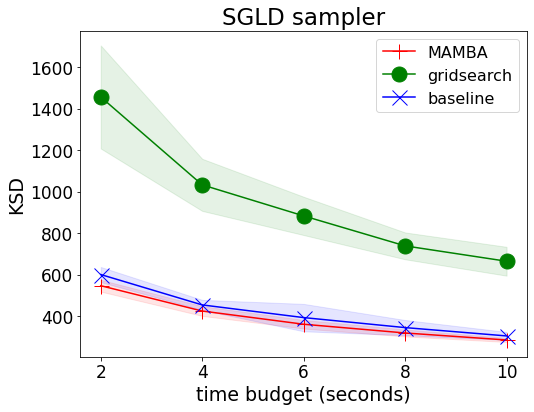

In [98]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgld_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_mamba+2*sd_ksd_curve_sgld_mamba, 
                 mean_ksd_curve_sgld_mamba-2*sd_ksd_curve_sgld_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgld_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_gridsearch+2*sd_ksd_curve_sgld_gridsearch, 
                 mean_ksd_curve_sgld_gridsearch-2*sd_ksd_curve_sgld_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgld_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_baseline+2*sd_ksd_curve_sgld_baseline, 
                 mean_ksd_curve_sgld_baseline-2*sd_ksd_curve_sgld_baseline, alpha=0.1, color='b')

plt.title("SGLD sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

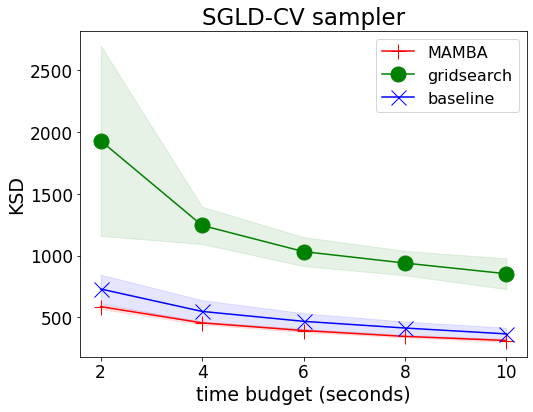

In [99]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_mamba+2*sd_ksd_curve_sgldCV_mamba, 
                 mean_ksd_curve_sgldCV_mamba-2*sd_ksd_curve_sgldCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_gridsearch+2*sd_ksd_curve_sgldCV_gridsearch, 
                 mean_ksd_curve_sgldCV_gridsearch-2*sd_ksd_curve_sgldCV_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_baseline+2*sd_ksd_curve_sgldCV_baseline, 
                 mean_ksd_curve_sgldCV_baseline-2*sd_ksd_curve_sgldCV_baseline, alpha=0.1, color='b')

plt.title("SGLD-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

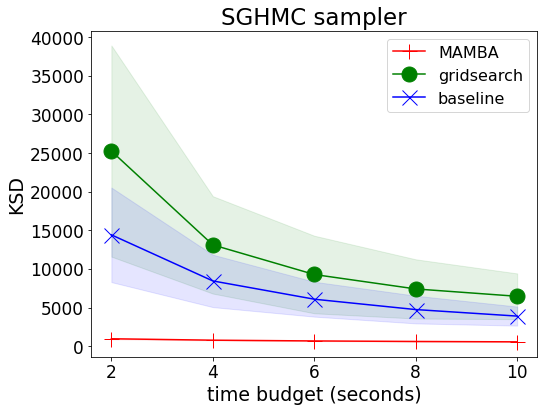

In [100]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmc_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_mamba+2*sd_ksd_curve_sghmc_mamba, 
                 mean_ksd_curve_sghmc_mamba-2*sd_ksd_curve_sghmc_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sghmc_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_gridsearch+2*sd_ksd_curve_sghmc_gridsearch, 
                 mean_ksd_curve_sghmc_gridsearch-2*sd_ksd_curve_sghmc_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sghmc_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_baseline+2*sd_ksd_curve_sghmc_baseline, 
                 mean_ksd_curve_sghmc_baseline-2*sd_ksd_curve_sghmc_baseline, alpha=0.1, color='b')

plt.title("SGHMC sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

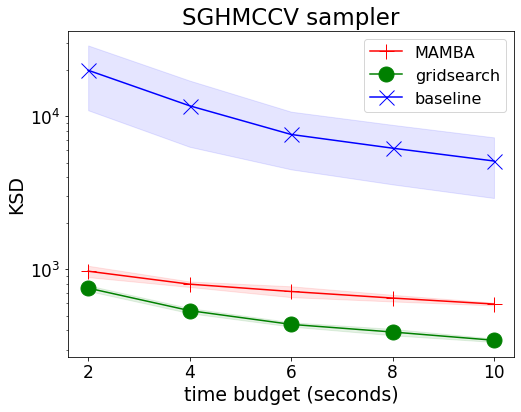

In [101]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_mamba+2*sd_ksd_curve_sghmcCV_mamba, 
                 mean_ksd_curve_sghmcCV_mamba-2*sd_ksd_curve_sghmcCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch+2*sd_ksd_curve_sghmcCV_gridsearch, 
                 mean_ksd_curve_sghmcCV_gridsearch-2*sd_ksd_curve_sghmcCV_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_baseline+2*sd_ksd_curve_sghmcCV_baseline, 
                 mean_ksd_curve_sghmcCV_baseline-2*sd_ksd_curve_sghmcCV_baseline, alpha=0.1, color='b')

plt.title("SGHMCCV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.yscale("log")
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

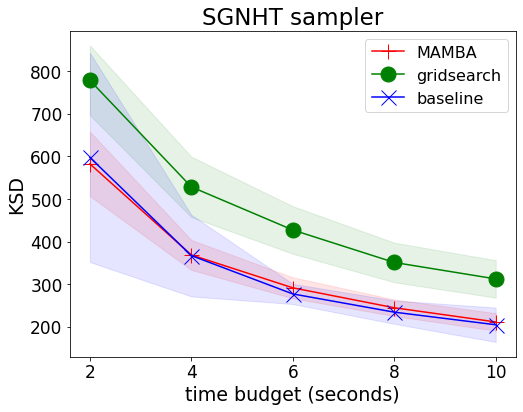

In [102]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnht_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_mamba+2*sd_ksd_curve_sgnht_mamba, 
                 mean_ksd_curve_sgnht_mamba-2*sd_ksd_curve_sgnht_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnht_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_gridsearch+2*sd_ksd_curve_sgnht_gridsearch, 
                 mean_ksd_curve_sgnht_gridsearch-2*sd_ksd_curve_sgnht_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgnht_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_baseline+2*sd_ksd_curve_sgnht_baseline, 
                 mean_ksd_curve_sgnht_baseline-2*sd_ksd_curve_sgnht_baseline, alpha=0.1, color='b')

plt.title("SGNHT sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

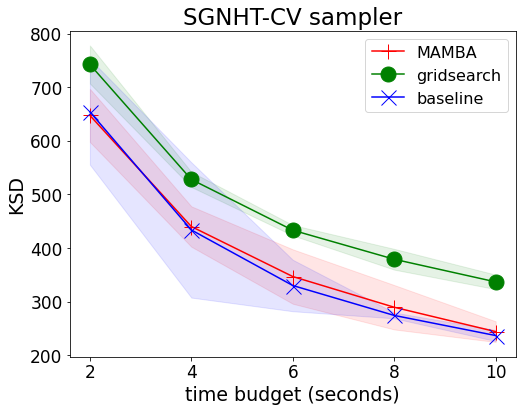

In [103]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_mamba+2*sd_ksd_curve_sgnhtCV_mamba, 
                 mean_ksd_curve_sgnhtCV_mamba-2*sd_ksd_curve_sgnhtCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch+2*sd_ksd_curve_sgnhtCV_gridsearch, 
                 mean_ksd_curve_sgnhtCV_gridsearch-2*sd_ksd_curve_sgnhtCV_gridsearch, alpha=0.1, color='g')

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_baseline, marker="x", markersize=15, 
         c='b', label="baseline")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_baseline+2*sd_ksd_curve_sgnhtCV_baseline, 
                 mean_ksd_curve_sgnhtCV_baseline-2*sd_ksd_curve_sgnhtCV_baseline, alpha=0.1, color='b')

plt.title("SGNHT-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")